In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [254]:
x = np.vstack([np.random.uniform(0,1,10000) for _ in range(2)]).T
y=(np.exp(x[:,0])+np.exp(x[:,1])).reshape((len(x),1))
xT = np.vstack([np.random.uniform(0,1,1000) for _ in range(2)]).T
yT=(np.exp(xT[:,0])+np.exp(xT[:,1])).reshape((len(xT),1))

In [264]:
xx = x#np.vstack([x[:,0],x[:,1],x[:,0]**2.,x[:,1]**2.]).T
xxT = xT#|np.vstack([xT[:,0],xT[:,1],xT[:,0]**2.,xT[:,1]**2.]).T

In [265]:
# Dimensions
dim_in = xx.shape[1]#trainX.shape[1]
dim_out= y.shape[1]#trainY.shape[1]

import torch
from torch.autograd import Variable

# Convert to torch variables
tr_input = Variable(torch.from_numpy(xx)).type(torch.FloatTensor)
tr_output = Variable(torch.from_numpy(y), requires_grad=False).type(torch.FloatTensor)

te_input = Variable(torch.from_numpy(xxT)).type(torch.FloatTensor)
te_output = Variable(torch.from_numpy(yT), requires_grad=False).type(torch.FloatTensor)


In [266]:
def one_layer_model(neurons=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.Tanh(),
        torch.nn.Linear(neurons,dim_out)
    )
    return model


In [267]:
def train_neural_network(model,epochs = 100,learning_rate = 0.1,verbose=True):
    loss_fn = torch.nn.L1Loss(reduction='elementwise_mean')

    # Use Adam optimizer with learning rate specified in parameter.py
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    # For loss records
    losslog = []
    epoch = []
    
    # Train neural network
    for i in range(epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer
        scheduler.step(loss) # Update learning rate

        if i % 10 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 50==0:
            if verbose:
                print("Training epoch %d of %d complete" %(i,epochs))
    
    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())

    print("L1 Loss value is {}".format(losslog[-1]))
    
    plt.plot(epoch,losslog,label=learning_rate)
    plt.ylabel("L1 Loss value")
    plt.xlabel("Epoch")
    plt.title("Loss plot")
    plt.legend()
    plt.show()
    
    pred_test = model(te_input)
    loss_test = loss_fn(pred_test,te_output)
    print("L1 Loss value is {}".format(loss_test.data[0]))
    
    return model_numpy,epoch,losslog


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 100 complete
Training epoch 50 of 100 complete
L1 Loss value is 0.07054394483566284


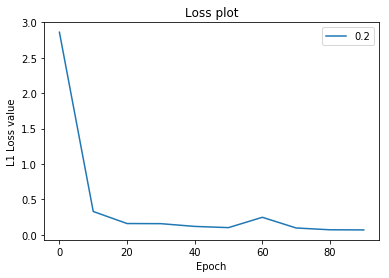

L1 Loss value is 0.06893220543861389


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [268]:
model,_,_=train_neural_network(one_layer_model(10),epochs=100,learning_rate=0.2,verbose=True)

In [260]:
def reconstruct(model,par):
    w0=np.asmatrix(model[0]).T
    w1=np.asmatrix(model[2])
    b0=np.asmatrix(model[1]).T
    b1=np.asmatrix(model[3])
    l1=np.matmul(np.asmatrix(par),w0)+b0.T
    out=np.matmul(w1,np.tanh(l1).T)+b1.T
    return float(out)

In [261]:
nn_T=np.asarray([reconstruct(model,xi) for xi in xxT])

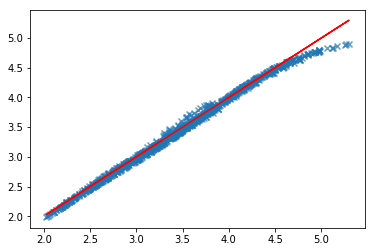

In [262]:
plt.scatter(yT,nn_T,marker='x',alpha=0.7)
plt.plot(yT,yT,c='r');

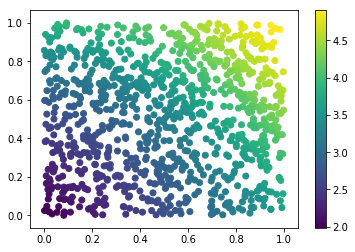

In [263]:
plt.scatter(xT[:,0],xT[:,1],c=nn_T);plt.colorbar()